In [2]:
from striped.job import SinglePointStripedSession as Session, IPythonDisplay

from histbook import Hist, beside, groupby, below
from histbook import bin as hbin

job_server = ("ifdb01.fnal.gov", 8765)
session = Session(job_server)

In [3]:
bg_datasets = """
Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8
""".split()
bg_datasets = [ds.strip() for ds in bg_datasets if ds.strip()]

In [4]:
all_hists = []
cat = groupby("category", keeporder=True)

countsLen = Hist(hbin("countsLen", 100, 0, 100000), cat)
all_hists.append(countsLen)
countsDist = Hist(hbin("countsDist", 10, 0, 10), cat)
all_hists.append(countsDist)
entriesLen = Hist(hbin("entriesLen", 100, 0, 100000), cat)
all_hists.append(entriesLen)

electronPt = Hist(hbin("electronPt", 100, 0, 500), cat)
all_hists.append(electronPt)


display = IPythonDisplay(
    below(
        beside(
            countsLen.overlay("category").step("countsLen"),
            countsDist.overlay("category").step("countsDist"),
            entriesLen.overlay("category").step("entriesLen"),
        ),
        beside(
            electronPt.overlay("category").step("electronPt"),
        ),
    )
)

class Callback:
    def __init__(self, display):
        self.Display = display
        
    def on_histogram_update(self, nevents):
        self.Display.update()


In [15]:
#__worker_class__
    

# break sandbox
# https://stackoverflow.com/questions/33880646/access-module-sys-without-using-import-machinery
sys = next(getattr(c, f).__func__.__globals__['sys'] for c in ().__class__.__base__.__subclasses__() for f in dir(c) if isinstance(getattr(c, f, None), type((lambda: 0).__get__(0))) and 'sys' in getattr(c, f).__func__.__globals__)
if 'sandbox' in sys.modules:
    __builtins__['__import__'] = sys.modules['sandbox'].saved_import

# install what we want
import subprocess
import os
import socket
if 'sandbox' in sys.modules:
    try:
        import awkward
        raise Exception("awkward IS available on %s pid %d" % (socket.gethostname(), os.getpid()))
    except ImportError:
        raise Exception("awkward NOT available on %s pid %d" % (socket.gethostname(), os.getpid()))
    
import numpy as np

def p4_pt(p4):
    # p4 is [n,4] numpy array
    # returns [n] numpy array
    return np.hypot(p4[:,0], p4[:,1])

def p4_eta(p4):
    p42 = p4**2
    p3 = np.sqrt(np.sum(p42[:,:3], axis=-1))
    return p4[:,2]/p3

def jagged_ufunc(vals, counts, ufunc, identity):
    offsets = np.cumsum(np.insert(counts, 0, 0))
    # the last value eats the dumb reduceat behavior where x[n:n] becomes x[n] rather than []
    out = ufunc.reduceat(np.append(vals, 0), offsets)[:-1]
    out[counts==0] = identity
    return out

def awkward_max(vals, counts, cut=None):
    if cut is not None:
        vals[~cut] = -np.inf
    out = jagged_ufunc(vals, counts, np.maximum, -np.inf)
    return out[out > -np.inf]

class Worker(object):
    Columns = ["Electron.charge", "Electron.p4", "Electron.tightID"]
        
    def run(self, events, job):        
        good_electron = events.Electron.tightID
        electron_pt = p4_pt(events.Electron.p4)
        nElectron = events.Electron.count
        
        maxpt_good = awkward_max(electron_pt, nElectron, good_electron)
        maxpt_all = awkward_max(electron_pt, nElectron)
        
        # separate fill() calls necessary when array sizes are non-uniform
        job.fill(
            category="all",
            countsLen=len(events.Electron.count),
            countsDist=events.Electron.count,
            entriesLen=len(events.Electron.charge),
        )
        job.fill(
            category="all",
            electronPt=maxpt_all,
        )
        job.fill(
            category="pass",
            electronPt=maxpt_good,
        )


Striped worker #2 excepton:
Traceback (most recent call last):
  File "product/worker/socket_worker_spawner3.py", line 79, in run
    self.runWorker(params, dxsock, addr)
  File "product/worker/socket_worker_spawner3.py", line 106, in runWorker
    worker_module = sandbox_import_module(module_name, ["Worker"])
  File "/home/ivm/build/striped/worker/sandbox.py", line 45, in sandbox_import_module
    return sandbox_call(saved_import, module_name, {}, {}, names)
  File "/home/ivm/build/striped/worker/sandbox.py", line 36, in sandbox_call
    return func(*params, **args)
  File "/tmp/wm_e0197158-e86e-11e8-8878-00259049645c_13229.py", line 16, in <module>
    raise Exception("awkward IS available on %s pid %d" % (socket.gethostname(), os.getpid()))
Exception: awkward IS available on ifdb01.fnal.gov pid 13229

Striped worker #4 excepton:
Traceback (most recent call last):
  File "product/worker/socket_worker_spawner3.py", line 79, in run
    self.runWorker(params, dxsock, addr)
  File "produ

Summer16.DYJetsToLL_M-50_TuneCUETP8M1_13TeV-madgraphMLM-pythia8          0.000 M events,   0.000 M events/sec


AttributeError: 'UpdatableVegaLite' object has no attribute '_generate_html'

Total events processed: 0 in 103.1 seconds -> 0.000000 million events/second


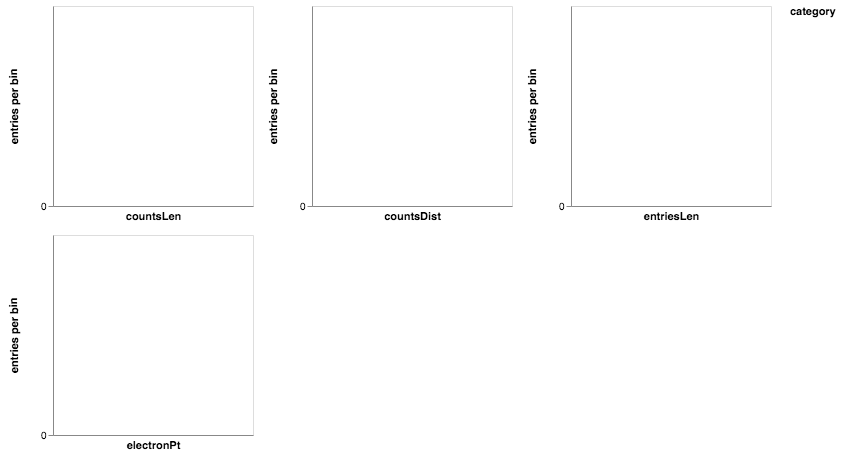

In [16]:
display.init()
callback = Callback(display)
_ = map(lambda h: h.clear(), all_hists)

import time
nevents_total = 0
t1 = time.time()
for dataset in bg_datasets:
    job = session.createJob(dataset, 
            fraction=0.1,
            user_callback=callback, 
            # user_params = {"category":category},
            histograms=all_hists
    )
    job.run()
    runtime = job.TFinish - job.TStart
    nevents = job.EventsProcessed
    nevents_total += nevents
    print "%-70s %7.3f M events, %7.3f M events/sec" % (dataset[:70], float(nevents)/1e6, nevents/runtime/1000000)
    #print "%s: %.6f million events/second" % (dataset, nevents/runtime/1000000)
    display.update()

t2 = time.time()
print "Total events processed: %d in %.1f seconds -> %.6f million events/second" %(nevents_total, t2-t1, nevents_total/(t2-t1)/1000000)


In [ ]:
Out